In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [2]:
!pip install seaborn

# **Exploratory Data Analysis**

In [3]:
# Load in df
df = pd.read_csv('stats.csv')
df.head()

,"last_name, first_name",player_id,year,ab,pa,home_run,strikeout,walk,k_percent,bb_percent,...,b_swinging_strike,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,"Beltré, Adrian",134181,2017,340,389,17,52,39,13.4,10.0,...,122,0.384,0.358,36.1,5.8,32.5,97.066970,92.551073,18.7,46.8
1,"Beltrán, Carlos",136860,2017,467,509,14,102,33,20.0,6.5,...,146,0.283,0.284,29.4,4.6,31.0,97.251447,92.653848,19.8,47.9
2,"Werth, Jayson",150029,2017,252,289,10,69,35,23.9,12.1,...,92,0.311,0.329,33.2,8.2,40.7,99.992580,94.104058,21.9,38.6
3,"Arroyo, Bronson",276520,2017,26,29,0,10,0,34.5,0.0,...,10,0.135,0.210,36.8,0.0,0.0,89.654834,89.315833,26.2,50.0
4,"Dickey, R.A.",285079,2017,61,68,0,12,0,17.6,0.0,...,17,0.129,0.139,19.6,0.0,0.0,83.338039,88.117691,14.8,74.3


In [4]:
# Shape of dataset
rows, cols = df.shape[0], df.shape[0]

print(f'Number of Rows: {rows}')
print(f'Number of Columns: {cols}')

Number of Rows: 5419
Number of Columns: 5419


In [5]:
# All columns
print(df.columns)

Index(['last_name, first_name', 'player_id', 'year', 'ab', 'pa', 'home_run',
       'strikeout', 'walk', 'k_percent', 'bb_percent', 'batting_avg',
       'slg_percent', 'on_base_percent', 'on_base_plus_slg', 'b_rbi',
       'b_swinging_strike', 'woba', 'xwoba', 'sweet_spot_percent',
       'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed',
       'avg_hyper_speed', 'whiff_percent', 'swing_percent'],
      dtype='object')


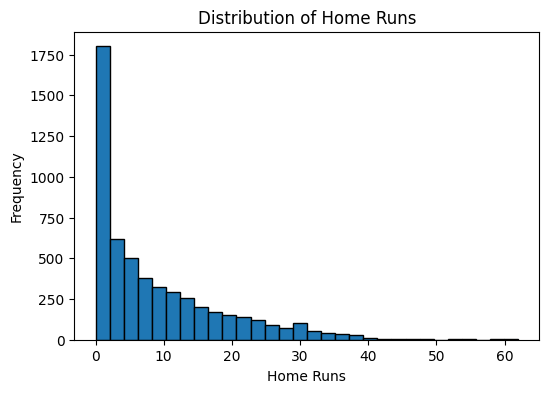

In [6]:
# distribution of target variable
plt.figure(figsize=(6,4))
plt.hist(df["home_run"], bins=30, edgecolor="black")
plt.xlabel("Home Runs")
plt.ylabel("Frequency")
plt.title("Distribution of Home Runs")
plt.show()

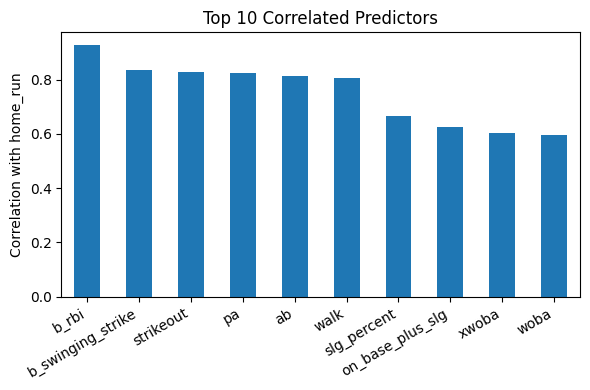

In [7]:
# top 10 correlations with home_run
corrs = df.corr(numeric_only=True)["home_run"].drop("home_run").sort_values(key=abs, ascending=False)
top10 = corrs.head(10)

plt.figure(figsize=(6,4))
top10.plot(kind="bar")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Correlation with home_run")
plt.title("Top 10 Correlated Predictors")
plt.tight_layout()
plt.show()

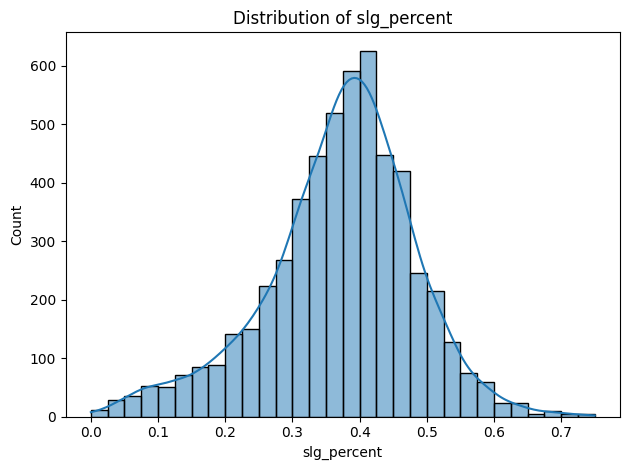

In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure()
sns.histplot(df['slg_percent'].dropna(), kde=True, bins=30)
plt.title(f"Distribution of {'slg_percent'}")
plt.xlabel('slg_percent')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

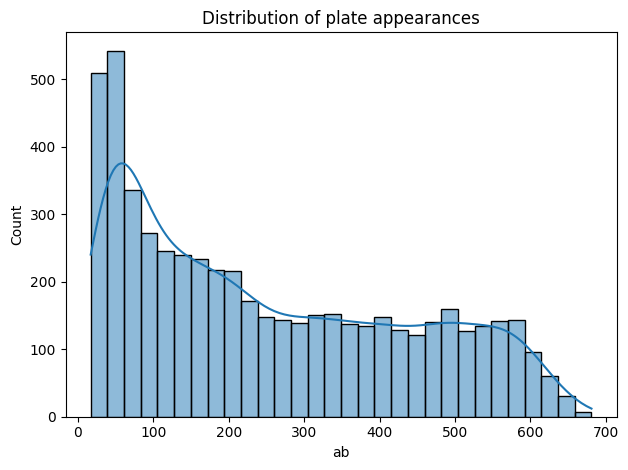

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure()
sns.histplot(df['ab'].dropna(), kde=True, bins=30)
plt.title(f"Distribution of {'plate appearances'}")
plt.xlabel('ab')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [10]:
# Filtering out rows where 'ab' (plate appearances) is less than or equal to 100
df = df[df['ab'] > 100]

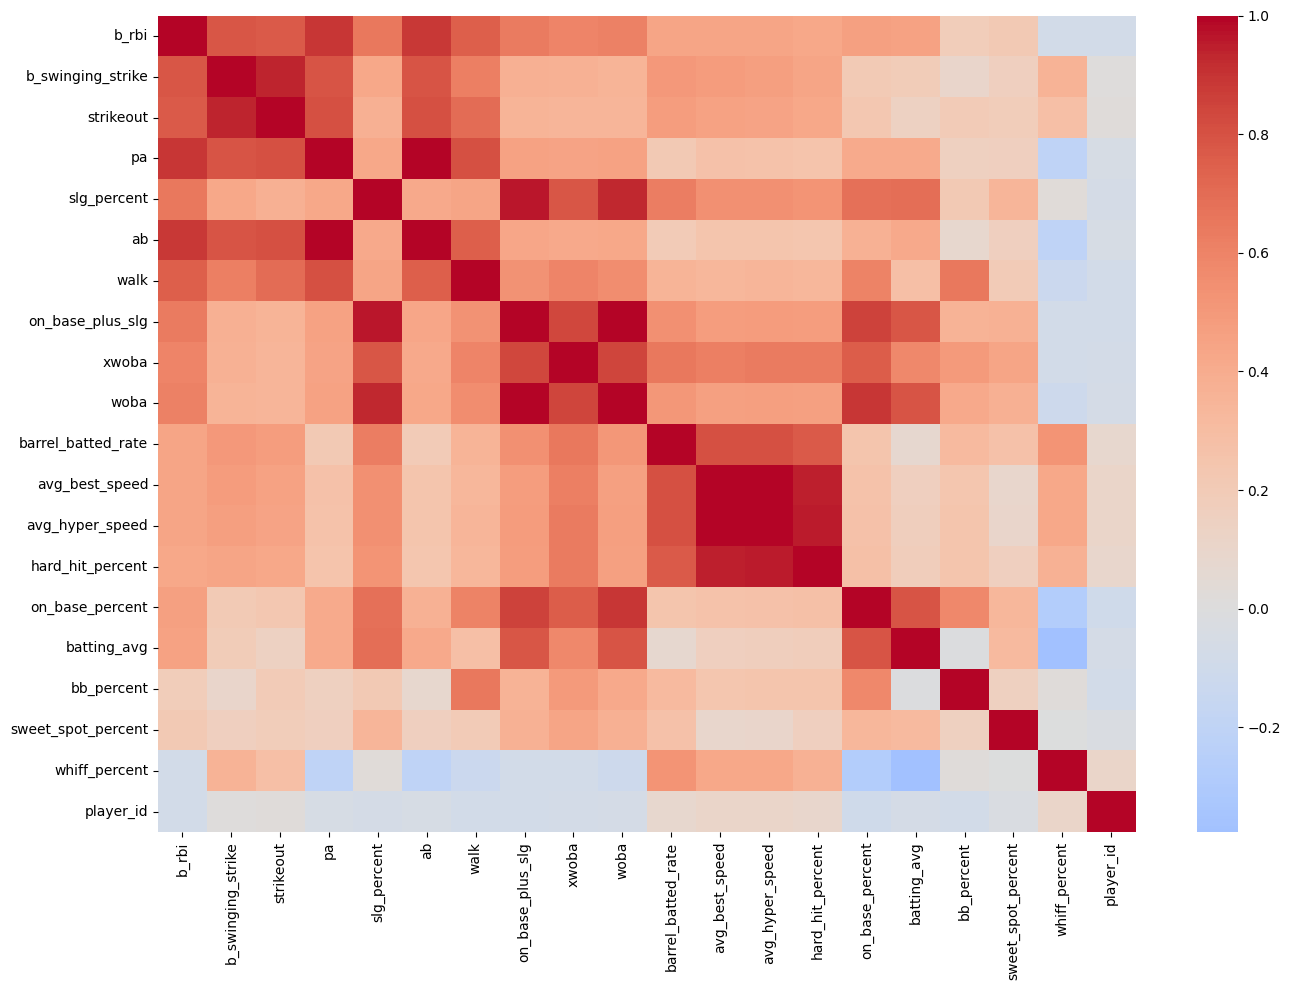

In [11]:
target = "home_run"
corr = df[numeric_cols].corr()
top20 = corr[target].abs().sort_values(ascending=False).index[1:21]
corr_top20 = corr.loc[top20, top20]
plt.figure(figsize=(14, 10))
sns.heatmap(corr_top20, annot=False, cmap="coolwarm", center=0)
plt.tight_layout()
plt.show()

## **Train/Test Split**

In [12]:
# remove non-numeric columns
id_cols = [col for col in df.columns if 'name' in col.lower() or 'id' in col.lower()]
df = df.drop(columns=id_cols, errors='ignore')

y = df['home_run']
X = df.drop(columns=['home_run'])

# split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (3048, 22)
Test shape: (763, 22)


# **Multiple Linear Regression**

### Model Variant 1: FINDING THE BEST NUMBER OF FEATURES BASED ON TOP 10 CORRELATED with `home_run`

In [13]:
# TOP CORRELATED FEATURES
corr_with_y = X_train.join(y_train).corr(numeric_only=True)['home_run'].drop('home_run')
corr_sorted = corr_with_y.sort_values(ascending=False)
k = 10
top_features = corr_sorted.head(k).index.tolist()
top_features

['b_rbi',
 'b_swinging_strike',
 'strikeout',
 'pa',
 'ab',
 'slg_percent',
 'walk',
 'on_base_plus_slg',
 'xwoba',
 'woba']

In [14]:
# Finding the best number of features from top 10 correlated features
results = []

for k in range(10, 0, -1):
    feats = top_features[:k]
    lr = LinearRegression()
    lr.fit(X_train[feats], y_train)


    y_pred_train = lr.predict(X_train[feats])
    y_pred_test  = lr.predict(X_test[feats])


    rmse_train = mean_squared_error(y_train, y_pred_train)
    rmse_test  = mean_squared_error(y_test, y_pred_test)
    r2_train   = r2_score(y_train, y_pred_train)
    r2_test    = r2_score(y_test, y_pred_test)

    results.append({
        'k': k,
        'features': feats,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r2_train': r2_train,
        'r2_test': r2_test
    })

cv_df = pd.DataFrame(results)
cv_df

,k,features,rmse_train,rmse_test,r2_train,r2_test
0,10,"[b_rbi, b_swinging_strike, strikeout, pa, ab, ...",7.312950,6.689299,0.924384,0.924340
1,9,"[b_rbi, b_swinging_strike, strikeout, pa, ab, ...",7.318639,6.681192,0.924325,0.924432
2,8,"[b_rbi, b_swinging_strike, strikeout, pa, ab, ...",7.447590,6.828535,0.922992,0.922765
3,7,"[b_rbi, b_swinging_strike, strikeout, pa, ab, ...",10.004387,8.860477,0.896554,0.899782
4,6,"[b_rbi, b_swinging_strike, strikeout, pa, ab, ...",10.155358,9.055509,0.894993,0.897577
5,5,"[b_rbi, b_swinging_strike, strikeout, pa, ab]",12.881918,11.326041,0.866801,0.871895
6,4,"[b_rbi, b_swinging_strike, strikeout, pa]",13.793484,12.485030,0.857375,0.858787
7,3,"[b_rbi, b_swinging_strike, strikeout]",16.701361,15.704075,0.827308,0.822377
8,2,"[b_rbi, b_swinging_strike]",16.761963,15.764885,0.826681,0.821689
9,1,[b_rbi],17.738387,16.611626,0.816585,0.812112


In [15]:
best_row = cv_df.sort_values('rmse_test').iloc[0]
k_best = best_row['k']
best_row, k_best

(k                                                             9
 features      [b_rbi, b_swinging_strike, strikeout, pa, ab, ...
 rmse_train                                             7.318639
 rmse_test                                              6.681192
 r2_train                                               0.924325
 r2_test                                                0.924432
 Name: 1, dtype: object,
 np.int64(9))

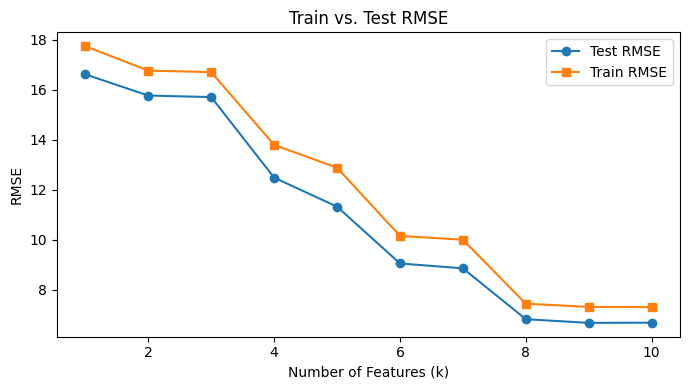

In [16]:
plt.figure(figsize=(7,4))
plt.plot(cv_df['k'], cv_df['rmse_test'], marker='o', label='Test RMSE')
plt.plot(cv_df['k'], cv_df['rmse_train'], marker='s', label='Train RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.title('Train vs. Test RMSE')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# OPTIMAL NUMBER OF FEATURES MODEL
summary_table = pd.DataFrame({
    'Metric': ['# of Features (k)', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²'],
    'Value': [k_best, round(best_row['rmse_train'], 3), round(best_row['rmse_test'], 3), round(best_row['r2_train'], 3), round(best_row['r2_test'], 3)]})
summary_table

,Metric,Value
0,# of Features (k),9.000
1,Train RMSE,7.319
2,Test RMSE,6.681
3,Train R²,0.924
4,Test R²,0.924


### Model Variant 2: Implementing Ridge Regression Using K-Fold Cross Validation

In [18]:
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

ridge_pipeline = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0, random_state=42))])
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "r2": "r2",
    "neg_mse": "neg_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "rmse": rmse_scorer
}

cv_results = cross_validate(ridge_pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

In [19]:
cv_table_per_fold = pd.DataFrame({
    "Fold": [1, 2, 3, 4, 5],
    "R2": cv_results["test_r2"],
    "MSE": -cv_results["test_neg_mse"],
    "MAE": -cv_results["test_neg_mae"],
    "RMSE": -cv_results["test_rmse"]
})

print("Cross-validation metrics per fold:")
print(cv_table_per_fold)

Cross-validation metrics per fold:
   Fold        R2       MSE       MAE      RMSE
0     1  0.929778  7.011258  1.973360  2.647878
1     2  0.930635  6.532602  1.914969  2.555895
2     3  0.937332  5.951239  1.895119  2.439516
3     4  0.940491  6.170954  1.925194  2.484141
4     5  0.931610  6.204252  1.901003  2.490834


In [20]:
ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)

test_metrics = pd.DataFrame({
    "MSE": [mean_squared_error(y_test, y_pred)],
    "RMSE": [(mean_squared_error(y_test, y_pred)) ** 0.5],
    "MAE": [mean_absolute_error(y_test, y_pred)],
    "R2": [r2_score(y_test, y_pred)]
}, index=["Test Set"])

print("\nTest-set evaluation:")
print(test_metrics)


Test-set evaluation:
               MSE      RMSE       MAE        R2
Test Set  5.730822  2.393914  1.843489  0.935181


In [21]:
alphas = np.logspace(-3, 3, 25)  # 0.001 to 1000
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])

param_grid = {"ridge__alpha": alphas}

grid = GridSearchCV(ridge_pipeline, param_grid=param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="neg_mean_squared_error",n_jobs=-1)
grid.fit(X_train, y_train)
best_alpha = grid.best_params_["ridge__alpha"]
print("Best alpha:", best_alpha)

Best alpha: 0.01778279410038923


In [22]:
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=0.01778279410038923, random_state=42))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "r2": "r2",
    "neg_mse": "neg_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "rmse": rmse_scorer
}

cv_results = cross_validate(ridge_pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

In [23]:
cv_table_per_fold = pd.DataFrame({
    "Fold": [1, 2, 3, 4, 5],
    "R2": cv_results["test_r2"],
    "MSE": -cv_results["test_neg_mse"],
    "MAE": -cv_results["test_neg_mae"],
    "RMSE": -cv_results["test_rmse"]
})

print("Cross-validation metrics per fold:")
print(cv_table_per_fold)

Cross-validation metrics per fold:
   Fold        R2       MSE       MAE      RMSE
0     1  0.930005  6.988598  1.974601  2.643596
1     2  0.931311  6.468931  1.907075  2.543409
2     3  0.938591  5.831731  1.879795  2.414898
3     4  0.940542  6.165705  1.919472  2.483084
4     5  0.931517  6.212728  1.899641  2.492534


In [24]:
ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)

test_metrics = pd.DataFrame({
    "MSE": [mean_squared_error(y_test, y_pred)],
    "RMSE": [(mean_squared_error(y_test, y_pred)) ** 0.5],
    "MAE": [mean_absolute_error(y_test, y_pred)],
    "R2": [r2_score(y_test, y_pred)]
}, index=["Test Set"])

print("\nTest-set evaluation:")
print(test_metrics)


Test-set evaluation:
               MSE      RMSE       MAE        R2
Test Set  5.723559  2.392396  1.849552  0.935263


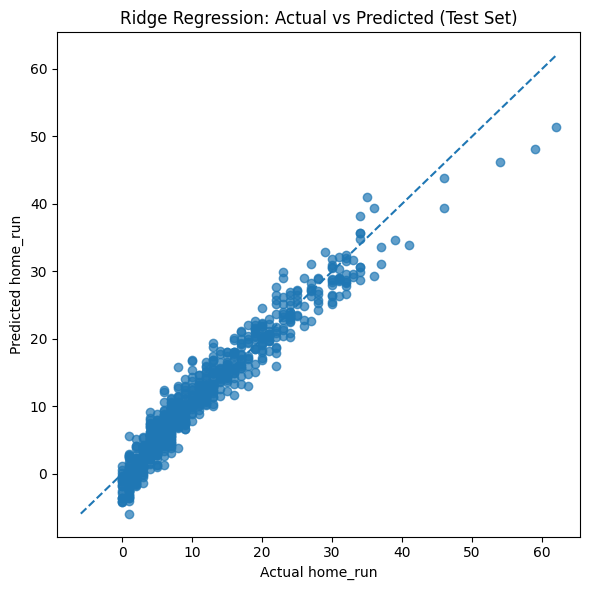

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual home_run")
plt.ylabel("Predicted home_run")
plt.title("Ridge Regression: Actual vs Predicted (Test Set)")
plt.tight_layout()
plt.show()

### Model Variant 3: Standardize Dataset to take Account Recent Baseball Factors

In [26]:

df3 = df.drop(columns=[col for col in df.columns if "name" in col.lower() or "id" in col.lower()]).copy()
log_vars = ["ab", "pa", "strikeout", "walk", "b_rbi", "b_swinging_strike"]
for col in log_vars:
    df3[col + "_log"] = np.log1p(df3[col])

df3["year_centered"] = df3["year"] - df3["year"].mean()
model3_features = ["ab_log", "pa_log", "strikeout_log", "walk_log", "b_rbi_log", "b_swinging_strike_log", "slg_percent", "xwoba", "woba", "year_centered"]
X3 = df3[model3_features]
y3 = df3["home_run"]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
model3 = Pipeline([("scaler", StandardScaler()),("ols", LinearRegression())])
model3.fit(X3_train, y3_train)
y3_pred = model3.predict(X3_test)
print("Model 3 R2:", r2_score(y3_test, y3_pred))
print("Model 3 RMSE:", np.sqrt(mean_squared_error(y3_test, y3_pred)))
print("Model 3 MAE:", mean_absolute_error(y3_test, y3_pred))


Model 3 R2: 0.841436327885702
Model 3 RMSE: 3.744196032519377
Model 3 MAE: 2.8501596221431518
